In [34]:
!pip3 install pyocto pyarrow

  Could not find a version that satisfies the requirement pyocto (from versions: )
No matching distribution found for pyocto


In [402]:
import pyocto
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections import Counter

## Input Data

In [635]:
picks = pd.read_csv("~/notebooks/data/phase_association/picks_first_half",index_col=0)
stations = pd.read_csv("~/notebooks/data/phase_association/stations_first_half",index_col=0)

In [636]:
picks

,station,phase,time
0,FS09B,P,2012-10-01T00:04:09.141700Z
1,FS09B,P,2012-10-01T00:36:41.601700Z
2,FS09B,P,2012-10-01T00:55:43.061700Z
3,FS09B,P,2012-10-01T01:16:07.681700Z
4,FS09B,P,2012-10-01T01:41:37.561700Z
...,...,...,...
1219,G25B,P,2012-10-14T04:50:49.077500Z
1220,G25B,P,2012-10-14T04:51:20.781500Z
1221,G25B,P,2012-10-14T04:56:46.781500Z
1222,G25B,P,2012-10-14T04:58:18.253500Z


  ## Velocoty Models

In [637]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)

In [638]:
# ?pyocto.VelocityModel0D

## Create a 1D velocity model

## The OctoAssociator class

In [640]:
associator = pyocto.OctoAssociator.from_area(
    lat=(40, 43.5),
    lon=(-126.5, -123),
    zlim=(0, 50),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=2,
    n_p_picks=1,
    n_s_picks=1,
    n_p_and_s_picks=1,
)

In [641]:
associator.crs

<Projected CRS: +proj=tmerc +lat_0=41.75 +lon_0=-124.75 +units=km  ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (kilometre)
- N[north]: Northing (kilometre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [642]:
associator.transform_stations(stations)
stations

,id,longitude,latitude,elevation,x,y,z
0,FS09B,-124.808502,40.438702,-2161.0,-4.963595,-145.625525,2.161
1,FS13B,-124.806503,40.493099,-2332.0,-4.790124,-139.585196,2.332
2,G10B,-125.553299,40.677898,-2936.0,-67.913996,-118.755232,2.936
3,G19B,-125.773598,41.307400,-3071.0,-85.719842,-48.651523,3.071
4,G25B,-124.586098,41.919899,-430.0,13.596424,18.883688,0.430


## Convert the timestamps to floats

In [643]:
picks["time"] = picks["time"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ'))

In [644]:
picks["time"] = picks["time"].apply(lambda x: x.timestamp())
picks

,station,phase,time
0,FS09B,P,1.349050e+09
1,FS09B,P,1.349052e+09
2,FS09B,P,1.349053e+09
3,FS09B,P,1.349054e+09
4,FS09B,P,1.349056e+09
...,...,...,...
1219,G25B,P,1.350190e+09
1220,G25B,P,1.350190e+09
1221,G25B,P,1.350191e+09
1222,G25B,P,1.350191e+09


In [645]:
type(1.349050e+09)

float

## Delete unnecessary columns

In [646]:
# picks.drop(columns="Unnamed: 0", inplace=True)
# picks

In [647]:
# stations.drop(columns="Unnamed: 0", inplace=True)
# stations

## Apply  the associator

In [648]:
events, assignments = associator.associate(picks, stations)

In [649]:
events

,idx,time,x,y,z,picks
0,0,1.349058e+09,-6.421393,-148.991401,5.859375,2
1,1,1.349062e+09,-2.918815,-147.467074,1.171875,2
2,2,1.349064e+09,-5.253867,-148.991401,8.203125,2
3,3,1.349066e+09,-104.493582,-113.931876,26.953125,2
4,4,1.349066e+09,-4.086341,-157.375201,7.421875,2
...,...,...,...,...,...,...
191,191,1.349567e+09,89.315744,-20.947918,42.578125,2
192,192,1.349567e+09,-1.751289,-132.223802,8.984375,2
193,193,1.349567e+09,-13.426550,-126.888657,1.953125,2
194,194,1.349568e+09,-9.923972,-139.845438,33.203125,2


In [650]:
Counter(events['picks'])

Counter({2: 190, 3: 5, 4: 1})

In [651]:
associator.transform_events(events)
events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,2012-10-01 02:11:56.598530+00:00,-6.421393,-148.991401,5.859375,2,40.408381,-124.825650,5.859375
1,1,2012-10-01 03:29:59.507308+00:00,-2.918815,-147.467074,1.171875,2,40.422128,-124.784393,1.171875
2,2,2012-10-01 03:53:48.871928+00:00,-5.253867,-148.991401,8.203125,2,40.408389,-124.811895,8.203125
3,3,2012-10-01 04:32:58.218543+00:00,-104.493582,-113.931876,26.953125,2,40.717502,-125.986693,26.953125
4,4,2012-10-01 04:41:23.697077+00:00,-4.086341,-157.375201,7.421875,2,40.332894,-124.798087,7.421875
...,...,...,...,...,...,...,...,...,...
191,191,2012-10-06 23:42:16.837714+00:00,89.315744,-20.947918,42.578125,2,41.556409,-123.679379,42.578125
192,192,2012-10-06 23:51:11.696993+00:00,-1.751289,-132.223802,8.984375,2,40.559403,-124.770678,8.984375
193,193,2012-10-06 23:51:18.862132+00:00,-13.426550,-126.888657,1.953125,2,40.607341,-124.908645,1.953125
194,194,2012-10-06 23:55:25.827837+00:00,-9.923972,-139.845438,33.203125,2,40.490710,-124.867056,33.203125


In [652]:
assignments

,event_idx,pick_idx,residual,station,phase,time
0,0,5,-0.000954,FS09B,P,1.349058e+09
1,0,122,0.000954,FS09B,S,1.349058e+09
2,1,7,-0.003348,FS09B,P,1.349062e+09
3,1,124,0.003348,FS09B,S,1.349062e+09
4,2,8,0.000847,FS09B,P,1.349064e+09
...,...,...,...,...,...,...
394,193,991,-0.010864,FS13B,S,1.349567e+09
395,194,697,0.000581,FS13B,P,1.349568e+09
396,194,993,-0.000581,FS13B,S,1.349568e+09
397,195,698,0.000724,FS13B,P,1.349568e+09


In [653]:
pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
0,0,2012-10-01 02:11:56.598530+00:00,-6.421393,-148.991401,5.859375,2,40.408381,-124.825650,5.859375,0,5,-0.000954,FS09B,P,1.349058e+09
1,0,2012-10-01 02:11:56.598530+00:00,-6.421393,-148.991401,5.859375,2,40.408381,-124.825650,5.859375,0,122,0.000954,FS09B,S,1.349058e+09
2,1,2012-10-01 03:29:59.507308+00:00,-2.918815,-147.467074,1.171875,2,40.422128,-124.784393,1.171875,1,7,-0.003348,FS09B,P,1.349062e+09
3,1,2012-10-01 03:29:59.507308+00:00,-2.918815,-147.467074,1.171875,2,40.422128,-124.784393,1.171875,1,124,0.003348,FS09B,S,1.349062e+09
4,2,2012-10-01 03:53:48.871928+00:00,-5.253867,-148.991401,8.203125,2,40.408389,-124.811895,8.203125,2,8,0.000847,FS09B,P,1.349064e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,193,2012-10-06 23:51:18.862132+00:00,-13.426550,-126.888657,1.953125,2,40.607341,-124.908645,1.953125,193,991,-0.010864,FS13B,S,1.349567e+09
395,194,2012-10-06 23:55:25.827837+00:00,-9.923972,-139.845438,33.203125,2,40.490710,-124.867056,33.203125,194,697,0.000581,FS13B,P,1.349568e+09
396,194,2012-10-06 23:55:25.827837+00:00,-9.923972,-139.845438,33.203125,2,40.490710,-124.867056,33.203125,194,993,-0.000581,FS13B,S,1.349568e+09
397,195,2012-10-06 23:56:57.064647+00:00,60.127592,40.787333,21.484375,2,42.114912,-124.022959,21.484375,195,698,0.000724,FS13B,P,1.349568e+09


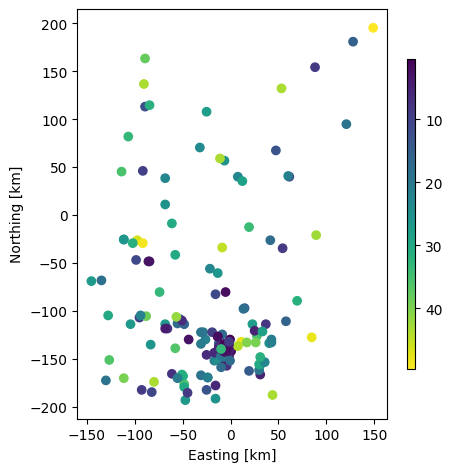

In [654]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

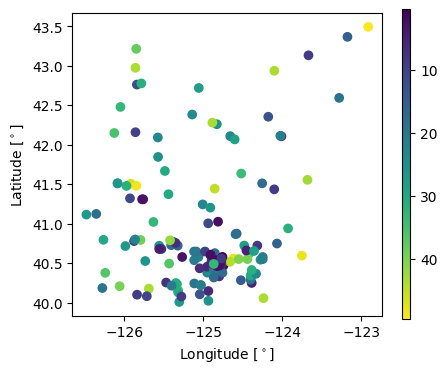

In [600]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

ax.set_xlabel("Longitude [$^\circ$]")
ax.set_ylabel("Latitude [$^\circ$]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["longitude"], events["latitude"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

In [531]:
len(events)

236

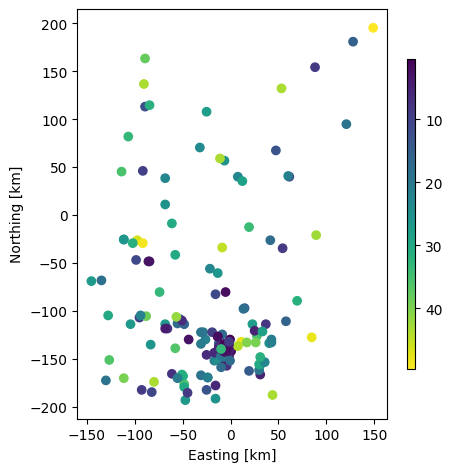

In [655]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()
